### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Define a problem, describe business context.
2. Load data, preclean it.
3. EDA: target, features.
4. Descibe train/test split strategy. Show main results and discuss them.
5. Run evth for a few periods. Show feature importance and error analysis.

### 1. Business problem

Stock market investors want to understand which assets to invest in. They try to identify best investment opportunities among US public stocks. So the problem is to predict which stocks will have the highest returns.

This problem is inherently very difficult. Asset management industry, managing over $100 Trillion, is constantly trying to solve this problem. As investors find best investment opportunities, they are being traded away. Thus uncovering even a very small predictability in stocks returns is a major success.

The aim of this project is to help investors to identify stocks, which will have high returns and avoid (or short) stocks with low returns. To make this problem more managebale, I abstact away of time-series variation in stock returns and focus on its cross-sectional component.

#### Objective:

Predict returns of US public stocks in the next month.

#### Metric:

R^2.

#### Summary of results:


### 2. Load data and preclean it

In [1]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_columns', 150)
gc.enable()

In [2]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
# Functions for Optuna NNs

cv_nn_regularizer = 0.075

def create_snnn4_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn4_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def create_snnn6_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn6_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def objective_nn4(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn4_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit
    
    
def objective_nn6(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn6_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit


In [5]:
time0 = time.time()

min_prd = 350
windows_width = 3*12
cv_xgb_regularizer=0.2
optuna_xgb_trials = 30
optuna_nn_trials = 30


with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
df_cnt = df.count()
empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
df.drop(columns=empty_cols, inplace=True)
display(df.shape)
#display(df.shape, df.head(), df.year.describe(), df.count())

features_miss_dummies = ['amhd', 'BAspr']
for col in features_miss_dummies:
    if col in df.columns:
        df[col+'_miss'] = df[col].isnull().astype(int)


(113964, 41)

### 3. EDA

The data has 1.1 M examples and 40 features. Since this is a panel data, each example is a firm-month observation. 39 features are numerical and 1 feature (industry) is a categorical. The features correspond to either accounting data or stock performance data. Accounting-based features are usually updated once per year, while stock price-based features change from month to month.

Target variable RET is a percentage return of a stock over month. Each month, I normalize stock returns by thier average. I do this to filter out time-series variation in aggregate stock market and focus on cross-sectional prediction. I trim target at -50% and +75% in order to avoid outliers. Many outliers, implying doubling of halving of stock price over 1 month, may reflect stock splits or conolidations. While these returns are computed, accounting for splits/consolidations, it is possible that there are some omissions, leading to implosible magnitude of returns. Even in cases where such an extreme return was not an error, it is likely to be driven by some extreme firm-level event. My current featur set is unlikely to be able to pick up such events.

In [6]:
df.head()

,prd,PERMNO,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l3amhd,l3MAX,l6amhd,l6MAX,l12amhd,l12MAX,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss
0,375,10005,NaN,-72.706514,1989,-10.581354,30.0,0.490174,-0.214332,0.0,-0.230583,-0.710000,-33.516946,NaN,0.765013,0.647098,0.843440,1.4066,0.866870,1.485001,3.167929,-0.424011,0.75014,-0.084639,0.015282,0.306039,-0.087557,NaN,1.4066,NaN,1.4066,NaN,1.4066,NaN,1.4066,-52.647854,0.765013,0.647098,0.380573,2.621943,6.827920,1
1,376,10005,NaN,-68.539010,1989,-29.162251,30.0,0.490174,-0.214332,0.0,-0.230583,-0.700000,-48.453613,NaN,0.765013,0.647098,0.569757,1.4066,0.866870,1.484870,2.598143,-0.424011,0.75014,-0.084639,0.015282,0.306039,0.163748,NaN,1.4066,NaN,1.4066,NaN,1.4066,NaN,1.4066,-61.937195,5.362759,5.279563,0.441740,3.313448,4.436441,1
2,377,10005,NaN,-60.041983,1989,-32.192019,30.0,0.490174,-0.214332,0.0,-0.230583,-20.740000,-48.510651,NaN,4.169273,3.399652,0.580613,1.4066,4.364358,2.310132,2.882070,-0.647218,0.75014,-0.084639,0.015282,0.306039,0.163748,NaN,1.4066,NaN,1.4066,NaN,1.4066,NaN,1.4066,-43.100755,0.765013,0.647098,0.456509,3.313442,4.197256,1
3,378,10005,NaN,-67.083392,1989,-1.127838,30.0,0.490174,-0.214332,0.0,-0.230583,-22.380465,-38.209694,NaN,5.565847,5.250996,0.663164,1.4066,6.813720,3.190628,2.799597,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.4066,NaN,1.4066,NaN,1.4066,NaN,1.4066,-22.391633,5.852977,5.112499,0.452695,4.107071,4.246072,1
4,379,10005,NaN,-70.826677,1989,28.314329,30.0,0.490174,-0.214332,0.0,-0.230583,-0.680000,-53.776947,NaN,0.765013,0.647098,0.372045,1.4066,0.866870,2.840962,2.265160,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.4066,NaN,1.4066,NaN,1.4066,NaN,1.4066,-36.888819,4.932686,3.778440,0.664521,4.378863,3.604576,1


<AxesSubplot:>

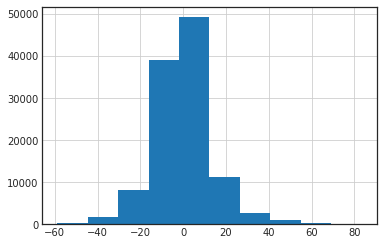

In [7]:
df.RET.hist()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113964 entries, 0 to 1271479
Data columns (total 42 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   prd           113964 non-null  int64  
 1   PERMNO        113964 non-null  int64  
 2   mom482        94004 non-null   float64
 3   mom242        112233 non-null  float64
 4   year          113964 non-null  int64  
 5   RET           113964 non-null  float64
 6   ind           113964 non-null  float64
 7   bm            113964 non-null  float64
 8   op            113964 non-null  float64
 9   gp            113964 non-null  float64
 10  inv           113865 non-null  float64
 11  mom11         113964 non-null  float64
 12  mom122        113964 non-null  float64
 13  amhd          84692 non-null   float64
 14  ivol_capm     113962 non-null  float64
 15  ivol_ff5      113962 non-null  float64
 16  beta_bw       113964 non-null  float64
 17  MAX           113964 non-null  float64
 18  vol

<AxesSubplot:>

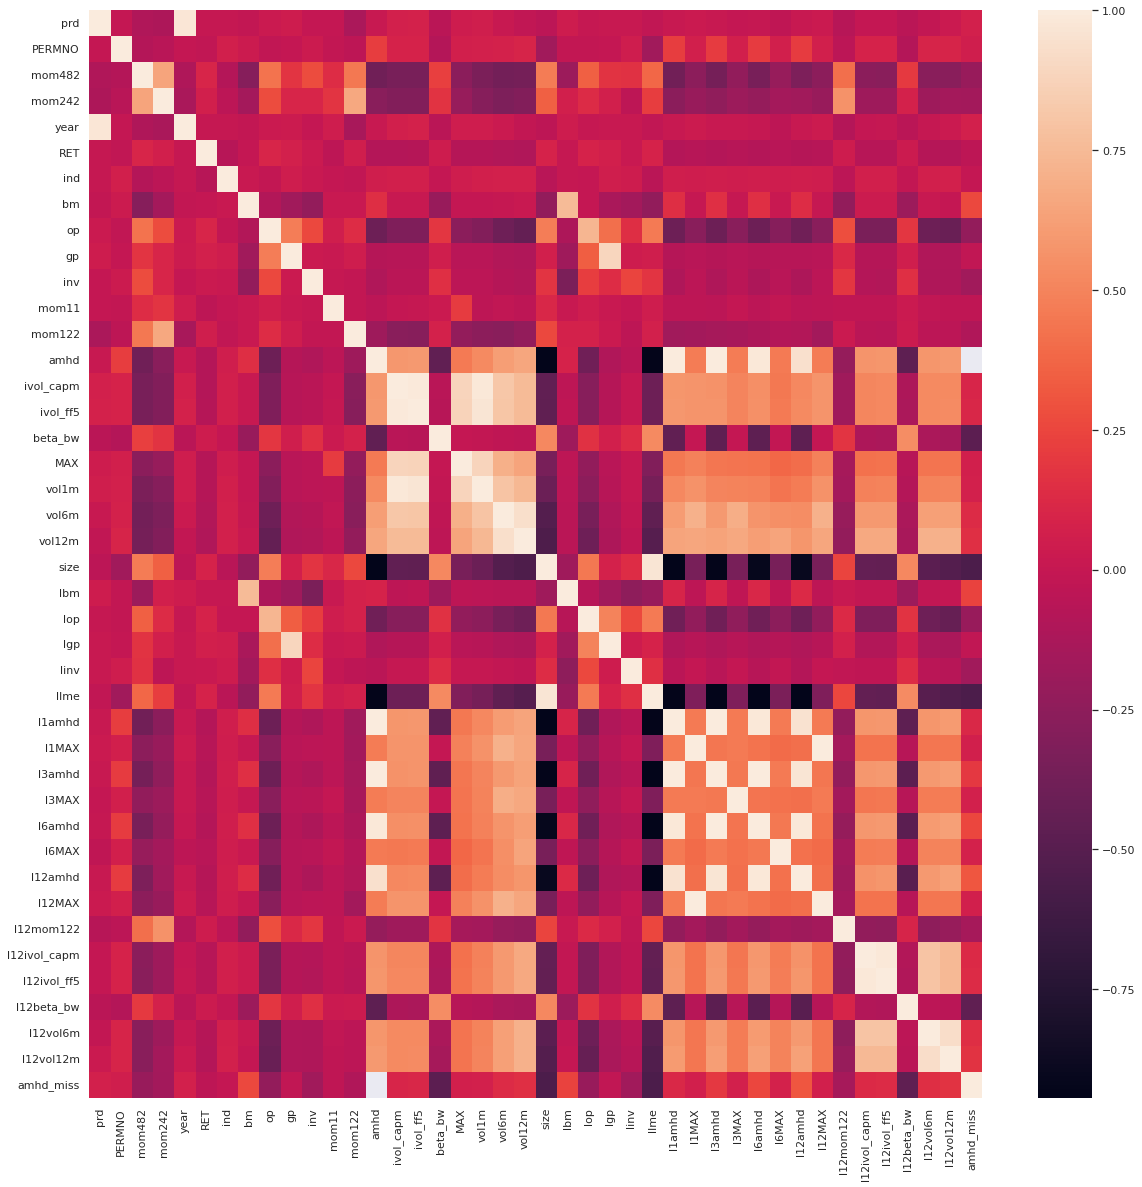

In [9]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df.corr())

<AxesSubplot:xlabel='count', ylabel='ind'>

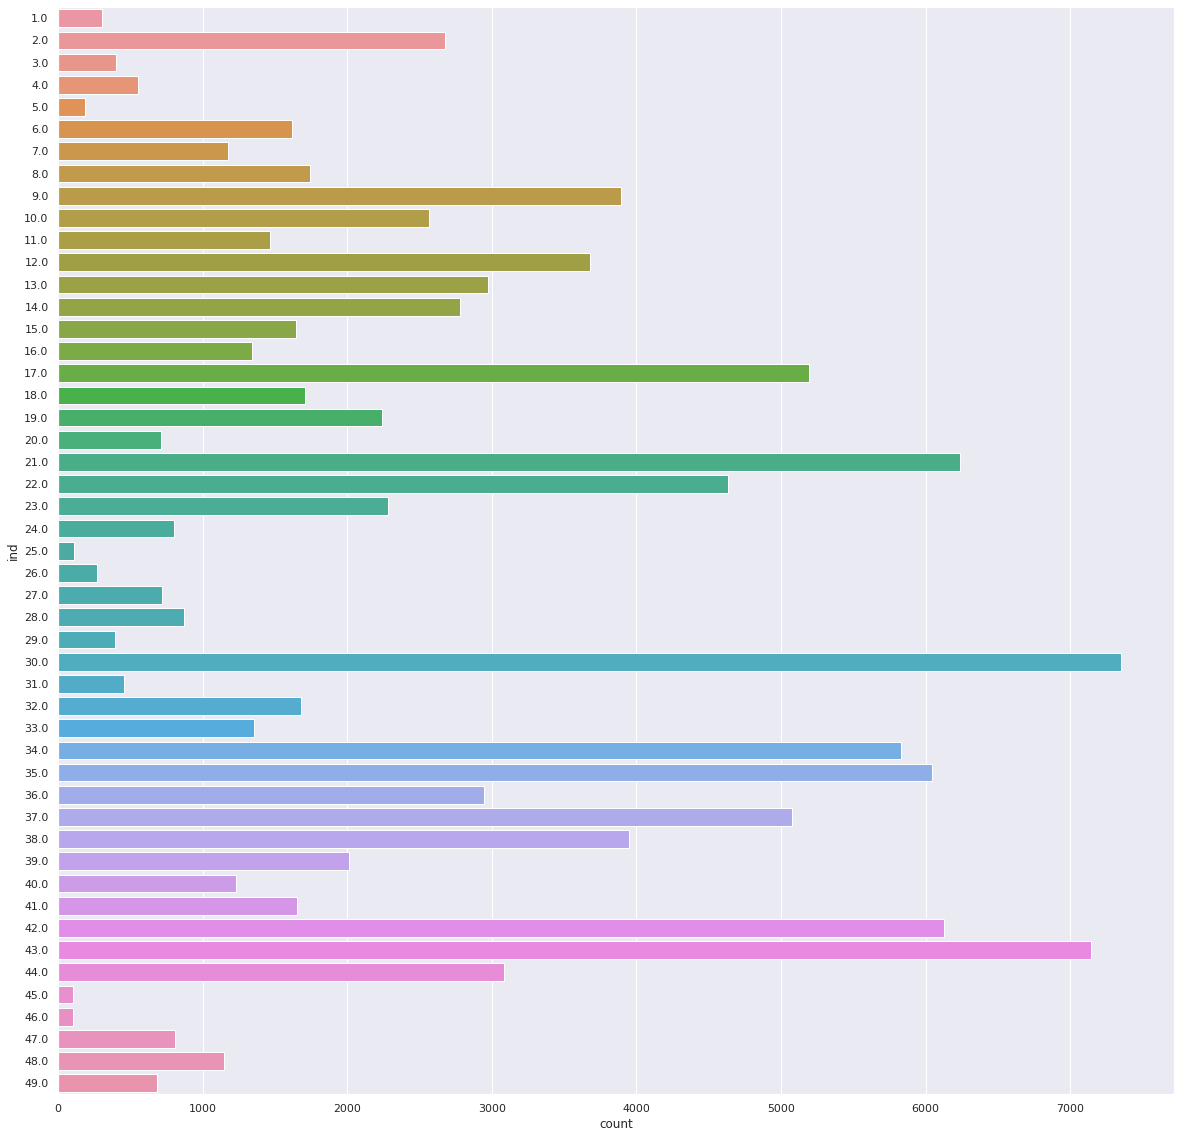

In [10]:
sns.countplot(y='ind', data=df)

### 4. Train/test split strategy

To be able to implement this startegy, we have to use only past data to make predictions. Thus we have to build the model, using time-based sample split.

Splitting sample once will result in the test sample, highly affected by trends during its time period. To avoid this problem, I use rolling train/validation/test split:

For each month t, I select all examples over months t-39 to t-4 to form train set. Then months between t-3 and t-1 comprise validation set. Finally, months from t to t+2 form test set. 

I use train set to train a model. I tune hyperparameters based on validation set. Then I evaluate model performance on test set. I use 3 months in both validation and test set to decrease variance of the model.



#### Main results

Below are the results from several model, utilizing sample split, described above. For now, I train and evaluate erformance of the models every two years. Doing this for every month is very computationally expensive. I will probably add such results later.

I used 7 variations of XGBoost and Deep Neural Networks:
1. Simple XGBoost with the following hyperparemters: n_estimators=400, max_dpeth=4, eta=0.02, subsample-0.6, colsample_bytree=0.4
2. XGBoost with hyperparameters chosen by grid search.
3. XGBoost with hyperparameters, chose by Optuna optimizer.
4. Neural network with 4 hidden layers.
5. Neural network with 6 hdden layers.
6. Neural netwok with 4 hidden layers and architecture/hyperpatemers chosen by Optuna.
7. Neural netwok with 6 hidden layers and architecture/hyperpatemers chosen by Optuna.

In [11]:
results_df = pd.read_csv('../input/mleap-v49-results/temp_models_reg005_1.csv')
results_df

,Unnamed: 0,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,0,100,0.110633,-0.010679,0.005897,0.032282,0.009775,0.016553,0.142414,0.097214,0.017316,0.092751,-0.004731,0.004806,0.077033,0.003310,0.007623,2.368052e-02,-0.006378,4.413288e-03,2.373109e-02,-1.185371e-03,0.006157
1,1,125,0.066434,0.004399,0.015985,0.040227,0.053275,0.020740,0.081517,0.077877,0.018348,0.020937,0.023310,0.014654,0.039157,0.018810,0.009496,-1.010410e-06,-0.000038,-1.945688e-05,-7.328776e-07,-3.910448e-05,-0.000020
2,2,150,0.064235,0.028400,-0.007106,0.108114,0.136225,-0.040268,0.102913,0.141299,-0.040073,0.039123,0.041242,-0.044962,0.046364,0.044968,-0.055987,4.366676e-02,0.040878,-4.501329e-02,5.041909e-02,4.294926e-02,-0.043427
3,3,175,0.073734,0.019790,-0.011655,0.093350,0.065665,0.000453,0.017994,0.013669,-0.002192,0.057370,0.021523,-0.006702,0.064954,0.017231,-0.010337,-4.252701e-06,-0.000010,-4.954723e-07,-7.191610e-09,-6.917556e-07,-0.000008
4,4,200,0.056176,0.048308,0.034120,0.111365,0.141292,0.040536,0.057042,0.089245,0.040346,0.041166,0.071331,0.022324,0.041645,0.073893,0.025533,3.709691e-02,0.065155,2.521314e-02,3.844909e-02,6.439698e-02,0.024244
5,5,225,0.064410,-0.005404,0.012234,0.083176,0.067360,0.026466,0.070134,0.033220,0.020088,0.055780,0.008508,0.012525,0.052652,0.008472,0.013793,-5.871936e-07,-0.000169,-1.014969e-04,-5.182621e-06,-1.285523e-04,-0.000073
6,6,250,0.061997,-0.017393,0.027061,0.018820,-0.001580,0.013451,0.189037,0.155622,0.031786,0.048662,-0.007640,0.024796,0.048832,-0.016709,-0.007211,-1.719546e-09,-0.000007,-2.775066e-06,-8.389908e-07,-2.850800e-06,-0.000007
7,7,275,0.084432,0.128375,0.097800,0.109516,0.192547,0.108320,0.102921,0.176972,0.108397,0.073269,0.144908,0.110993,0.070322,0.143302,0.112889,7.233643e-02,0.144175,1.100276e-01,7.211387e-02,1.423667e-01,0.106699
8,8,300,0.109596,0.041026,0.083551,0.097602,0.058866,0.086605,0.098751,0.054814,0.084547,0.098849,0.040880,0.086885,0.095496,0.042473,0.086713,1.023098e-01,0.039196,8.664547e-02,9.784490e-02,3.844309e-02,0.087651
9,9,325,0.111924,0.042263,-0.038793,0.133787,0.091224,-0.039374,0.112554,0.067039,-0.034580,0.106888,0.049632,-0.052411,0.104488,0.049346,-0.055748,9.684091e-02,0.041965,-6.858033e-02,1.009017e-01,4.594199e-02,-0.066538


In [12]:
results_df.iloc[:,2:].mean()

xgbf_train      0.065623
xgbf_val        0.021075
xgbf_test       0.019406
xgbgs_train     0.067792
xgbgs_val       0.062753
xgbgs_test      0.024652
xgbo_train      0.069877
xgbo_val        0.061347
xgbo_test       0.023288
nn4_train       0.049962
nn4_val         0.031291
nn4_test        0.018665
nn6_train       0.051145
nn6_val         0.030294
nn6_test        0.015159
nn4opt_train    0.030038
nn4opt_val      0.025225
nn4opt_test     0.013710
nn6opt_train    0.030471
nn6opt_val      0.025977
nn6opt_test     0.011148
dtype: float64

### 5. Fit the model(s) for one window and explore results

(86525, 41)

(7274, 41)

(7655, 41)

Number of features before transformation:  (86525, 38)
time to do feature proprocessing: 
Number of features after transformation:  (86525, 86) (7274, 86) (7557, 86) (7655, 86)
mae of a constant model 9.829729636954092
R2 of a constant model 0.0
fixed XGB train: 8.691436727915313 0.10293313911685331
XGB val: 9.717708335125423 0.03999212025983656
XGB val extra: 12.284157764400447 0.03759872132638431
XGB test: 10.465530780239735 -0.0063821723842552025
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04241707807354467 63.042941093444824
XGB train: 8.695012267727543 0.09907150614417448
XGB validation: 9.559585257648125 0.070611187303669
XGB validation extra: 11.972006867399784 0.08163841109742664
XGB test: 10.47468523195892 -0.0059672654136349035
Total time for hypermarameter optimization, XGB:  129.9040286540985
        n_estimators : 1236
           max_depth : 4
       learning_rate : 0.007241686763940576
    colsample_bytree : 0.110

2022-10-04 19:44:48.941939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 19:44:48.943184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 19:44:48.943895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 19:44:48.944724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

3833


2022-10-04 19:44:56.315621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Minimum Validation Loss: 193.5078
3489
Minimum Validation Loss: 192.8755


'Optuna NN4'

{'neurons_base': 8,
 'l2_regularizer': 0.18397454728944887,
 'l1_regularizer': 0.48238973740614993}

212.1995997428894

[8, 0.18397454728944887, 0.48238973740614993]

Time for hyperparameter optimization:  212.20684909820557 [8, 0.18397454728944887, 0.48238973740614993]


'Optuna NN6'

{'neurons_base': 4,
 'l2_regularizer': 0.05767063946831591,
 'l1_regularizer': 0.08926469409402751}

277.98627638816833

[4, 0.05767063946831591, 0.08926469409402751]

Time for hyperparameter optimization:  277.993604183197 [4, 0.05767063946831591, 0.08926469409402751]
total time for the script:  907.2793400287628


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.084806,0.061269,0.013369,0.089623,0.048966,-0.01096,0.090369,0.049605,-0.012188,0.080676,0.042052,-0.016475,0.086824,0.045802,-0.01394


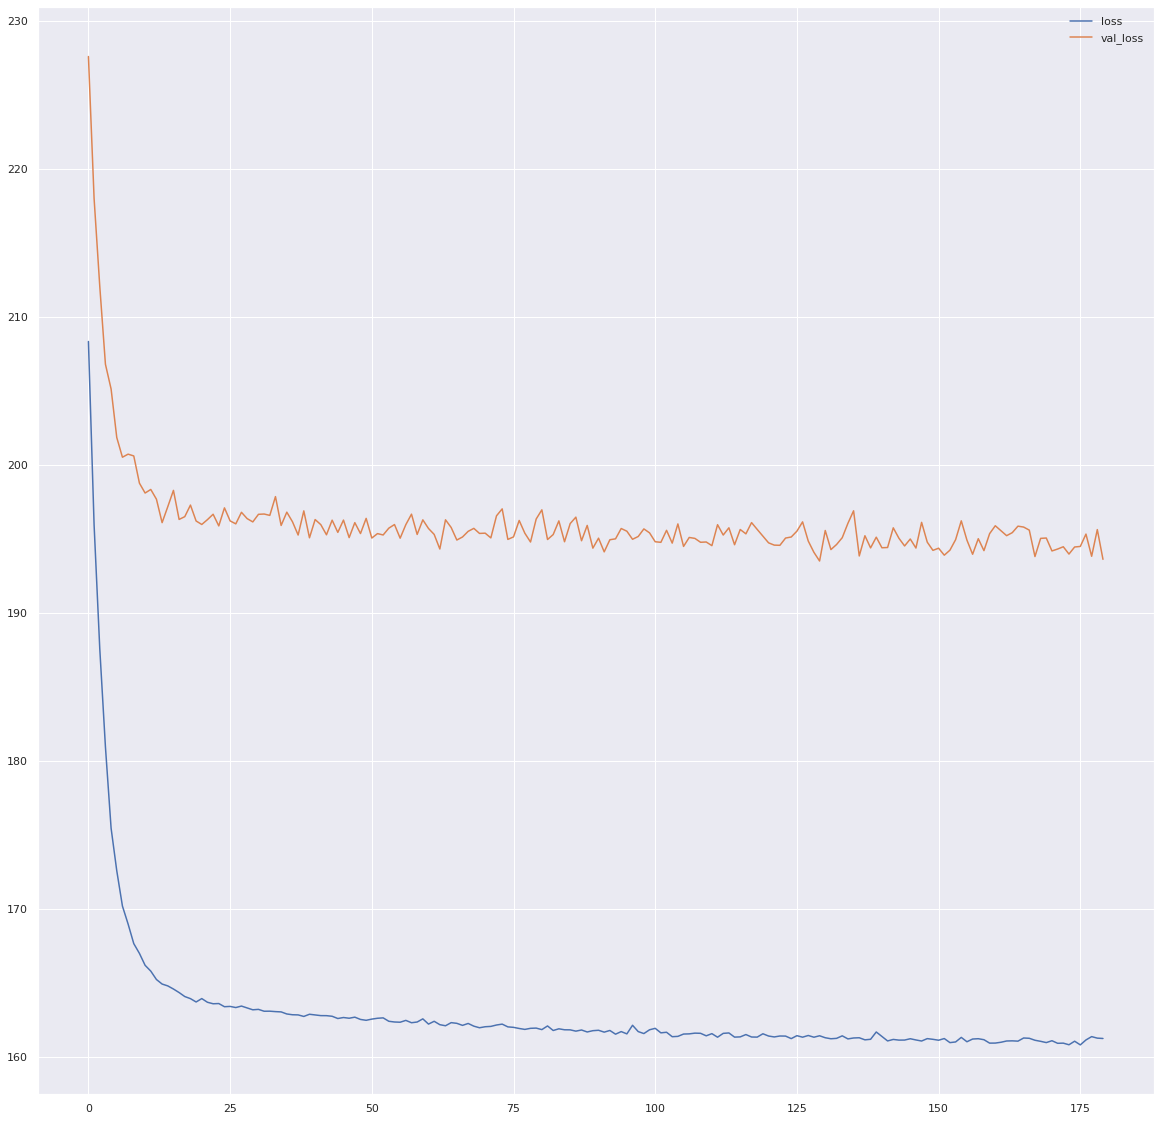

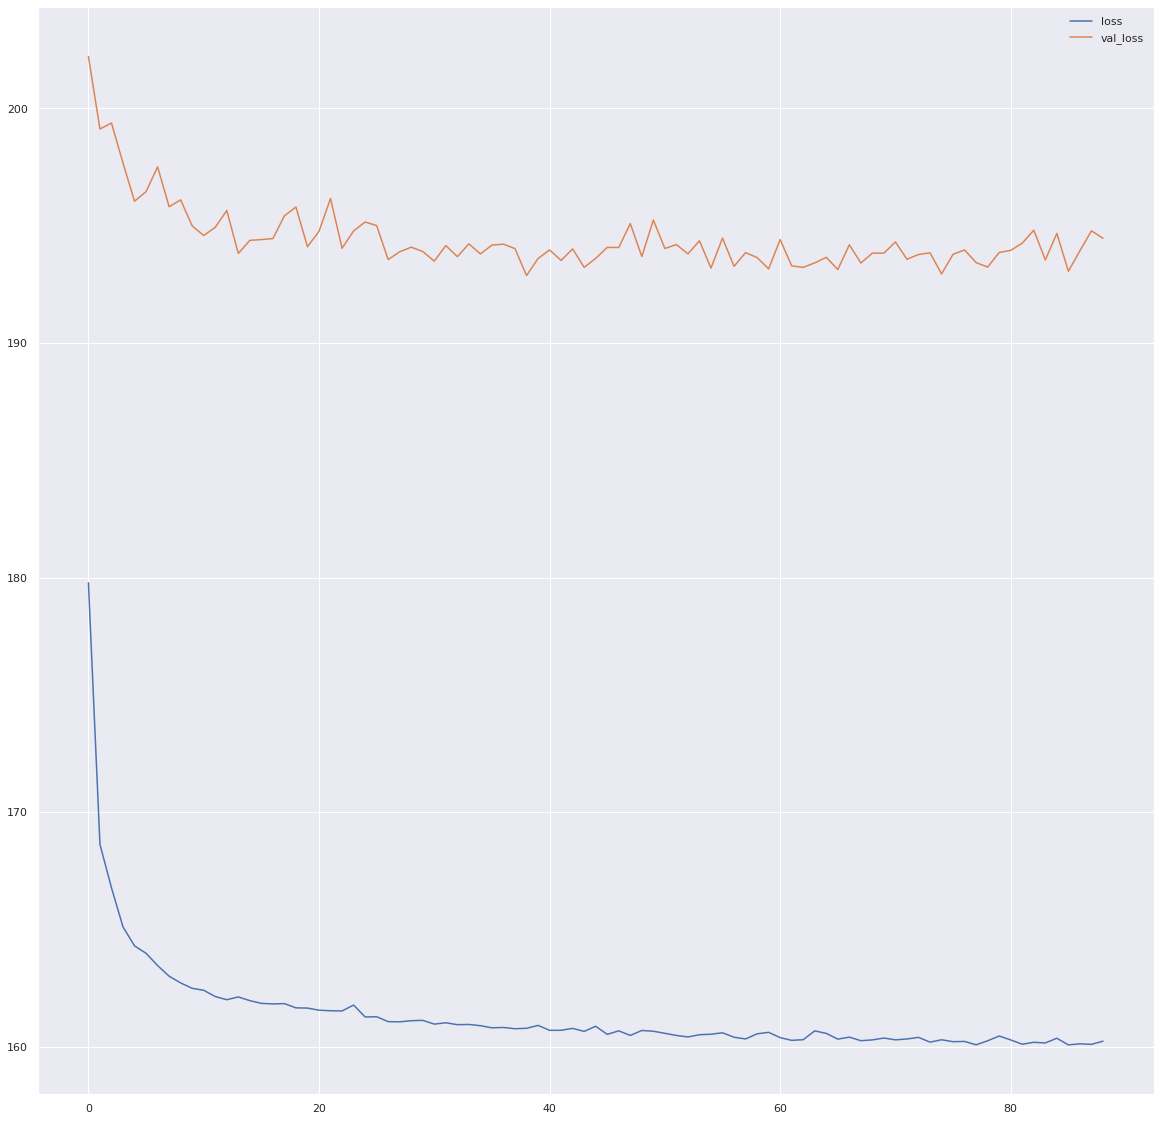

In [13]:
temp_cols = ['PERMNO', 'year', 'prd']
df.reset_index(inplace=True, drop=True)
X = df.copy()
y = X.pop('RET')

train_indx = X.prd<(min_prd+windows_width-1)
val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

X_train = X[train_indx]
X_val = X[val_indx]
X_val_extra = X[val_indx_extra]
X_test = X[test_indx]
y_train = y[train_indx]
y_val = y[val_indx]
y_val_extra = y[val_indx_extra]
y_test = y[test_indx]

#display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
#display(X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())
display(X_train.shape, X_val.shape, X_test.shape)

X_train.drop(columns=temp_cols, inplace=True)
X_val.drop(columns=temp_cols, inplace=True)
X_val_extra.drop(columns=temp_cols, inplace=True)
X_test.drop(columns=temp_cols, inplace=True)

#display(X_train.tail())
col_cat = ['ind']
col_num = [x for x in X_train.columns if x not in col_cat]
for col in col_num:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_val[col] = X_val[col].fillna(X_train[col].median())
    X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_train[col].median())
for col in col_cat:
    X_train[col] = X_train[col].fillna(value=-1000)
    X_val[col] = X_val[col].fillna(value=-1000)
    X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
    X_test[col] = X_test[col].fillna(value=-1000)

#display(X_train.tail())
feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                        ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                        remainder="passthrough")

print('Number of features before transformation: ', X_train.shape)
train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ')
print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
X_train.index = train_index
X_val.index = val_index
X_val_extra.index = val_index_extra
X_test.index = test_index
#display(X_train.tail())

X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])
#display(X,y)

X_ = pd.concat([X_train, X_val, X_val_extra])
y_ = pd.concat([y_train, y_val, y_val_extra])
#display(X,y, X_,y_)


results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test',
                                 'nn6opt_train', 'nn6opt_val', 'nn6opt_test'])

results['min_prd'] = [min_prd]


### Modeling part ###

print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
xgb1.fit(X_train, y_train)
print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
[r2_score(y_train, xgb1.predict(X_train)), 
r2_score(y_val, xgb1.predict(X_val)),
r2_score(y_test, xgb1.predict(X_test))]

time1 = time.time()

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train.index else 0 for x in X.index]
pds = PredefinedSplit(test_fold = split_index)

xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
              'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

# Fit with all data
xgbgs.fit(X_, y_)

print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
[r2_score(y_train, xgbgs.predict(X_train)), 
r2_score(y_val, xgbgs.predict(X_val)),
r2_score(y_test, xgbgs.predict(X_test))]

time1 = time.time()
def objective_xgb(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    params = {
    "tree_method": 'gpu_hist',
    "verbosity": 0,  # 0 (silent) - 3 (debug)
    "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
    "max_depth": trial.suggest_int("max_depth", 2, 6),
    "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
    "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
    "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
    "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
    "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
    "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

    model = XGBRegressor(**params, njobs=-1)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

    score_train = r2_score(y_train, model.predict(X_train))
    score_val = r2_score(y_val, model.predict(X_val))
    score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
    score_val = (score_val+score_val_extra)/2
    overfit = np.abs(score_train-score_val)

    return score_val-cv_xgb_regularizer*overfit


study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb, n_trials=optuna_xgb_trials)
print('Total time for hypermarameter optimization, XGB: ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")
optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X, y)
print('Optuna XGB train: \n', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
      mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
      mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
      mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
[r2_score(y_train, optuna_xgb.predict(X_train)), 
r2_score(y_val, optuna_xgb.predict(X_val)),
r2_score(y_test, optuna_xgb.predict(X_test))]

###########
### NNs ###
###########

neurons_base = 8
l2_reg_rate = 0.5

model_snn6 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn6.count_params())

early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
optimizer_adam = tf.keras.optimizers.Adam()

model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

time1 = time.time()
history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
[r2_score(y_train, model_snn6.predict(X_train)), 
r2_score(y_val, model_snn6.predict(X_val)),
r2_score(y_test, model_snn6.predict(X_test))]



neurons_base = 8
l2_reg_rate = 0.3

model_snn4 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn4.count_params())

time1 = time.time()
model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
[r2_score(y_train, model_snn4.predict(X_train)), 
r2_score(y_val, model_snn4.predict(X_val)),
r2_score(y_test, model_snn4.predict(X_test))]



# try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

time1 = time.time()
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective_nn4, n_trials=optuna_nn_trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
temp = study.best_params
display('Optuna NN4', study.best_params, time.time()-time1)

optimal_hyperpars = list(temp.values())
display(optimal_hyperpars)
print('Time for hyperparameter optimization: ',time.time()-time1, optimal_hyperpars)

optuna_nn = create_snnn4_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                         l2_reg_rate=optimal_hyperpars[1],
                                        l1_reg_rate=optimal_hyperpars[2])
history = optuna_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=2048, 
                        epochs=1000,
                        verbose=0, 
                        callbacks=[early_stopping50])

results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]


time1 = time.time()
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective_nn6, n_trials=optuna_nn_trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
temp = study.best_params
display('Optuna NN6', study.best_params, time.time()-time1)

optimal_hyperpars = list(temp.values())
display(optimal_hyperpars)
print('Time for hyperparameter optimization: ', time.time()-time1, optimal_hyperpars)

optuna_nn = create_snnn6_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                         l2_reg_rate=optimal_hyperpars[1],
                                        l1_reg_rate=optimal_hyperpars[2])
history = optuna_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=2048, 
                        epochs=1000,
                        verbose=0, 
                        callbacks=[early_stopping50])

results.loc[results.min_prd==min_prd,'nn6opt_train':'nn6opt_test'] = \
[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]


print('total time for the script: ', time.time()-time0)
display(results)

### Feature Importance

  0%|          | 0/10 [00:00<?, ?it/s]

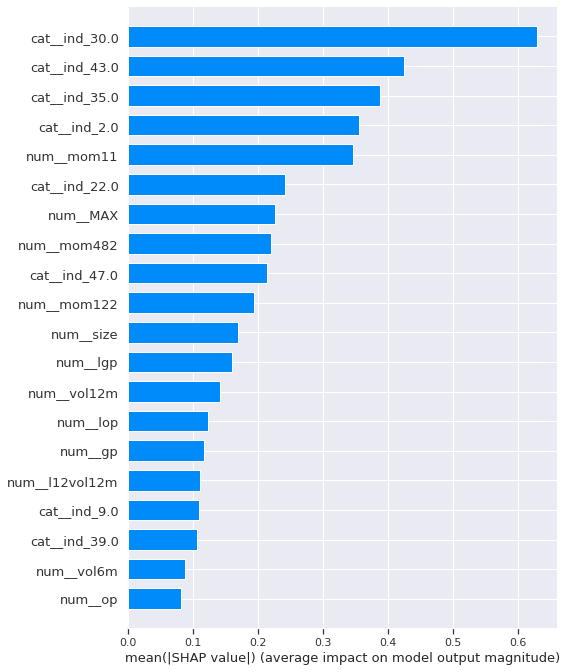

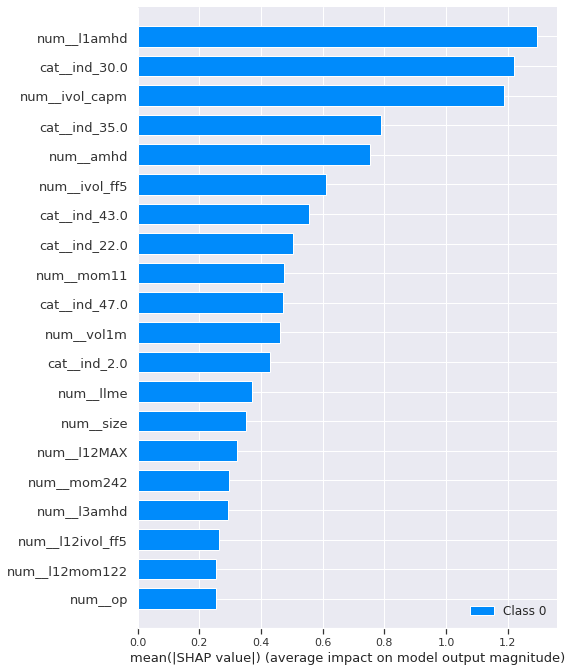

'time to run feature importances: '

128.21912789344788

In [24]:
### Feature Importance

# use both shap and sklearn fi

time2 = time.time()

X_test_shap = X_test.sample(10)

explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test_shap)
vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance_xgb = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col','feature_importance_vals'])

#select backgroud for shap
background = X_train.sample(1000)
explainernn = shap.KernelExplainer(optuna_nn, background)
shap_values_nn_test = explainernn.shap_values(X_test_shap)
shap.summary_plot(shap_values_XGBoost_test,X_test,feature_names=X_test.columns, plot_type = 'bar')
plt.show()
shap.summary_plot(shap_values_nn_test,X_test,feature_names=X_test.columns)
plt.show()
#display(feature_importance_xgb[:20])
display('time to run feature importances: ', time.time()-time2)

In [46]:
# try scikit-learn feature importances:

gc.collect()
time2 = time.time()

fi_test_size = 10
test_ind = random.sample(list(y_test.index), fi_test_size)
X_test_ss = X_test.loc[test_ind]
y_test_ss = y_test.loc[test_ind]
display(X_test_ss, y_test_ss)

# scikit-learn FI
results_fi = permutation_importance(optuna_xgb, X_test_ss, y_test_ss, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)
display(time.time()-time2, fi)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
12246,0.101533,0.591631,0.637388,-0.367506,-1.512899,-0.377980,-0.030177,0.551670,0.598132,-0.515466,-0.723296,-0.263622,-0.623644,-0.643649,-0.589236,-0.657232,0.359017,1.491619,-0.963446,-1.778142,-1.251531,0.075762,0.704516,-0.302911,0.093412,-0.694232,0.095726,-0.526952,0.597952,-0.302911,0.919617,-0.315401,-0.535236,-1.109617,-0.322148,-0.707273,-0.568822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51311,0.538535,1.155798,-2.325733,-1.120508,-1.214644,-0.799929,-0.899997,2.711805,-0.707663,0.683556,0.527419,1.305426,0.081862,0.767905,0.204708,-0.112176,0.727241,-0.880827,-0.936680,-1.374860,0.598276,0.289882,-0.664398,0.346399,-0.658584,-0.178049,-0.579789,0.175949,-0.299349,0.346399,-0.892102,-0.208066,-0.064511,1.790766,-0.512639,-0.670666,-0.568822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6265,-0.205386,0.851442,-0.767985,1.348503,2.031511,0.851825,2.335565,-0.684418,0.515483,0.956764,0.659647,0.179133,2.129854,0.813138,0.166262,0.130244,0.325211,-1.102174,1.692909,2.045062,0.648402,0.300006,0.506545,-0.941791,0.395551,-0.364799,0.103179,-0.194624,0.253756,-0.941791,0.718014,-0.238792,-0.319159,0.676380,-0.320549,-0.299440,-0.568822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


12246    -3.322303
51311    17.120961
6265    -30.273137
Name: RET, dtype: float64

XGBoostError: [20:24:29] ../src/c_api/../data/../common/common.h:46: ../src/c_api/../data/../common/device_helpers.cuh: 151: cudaErrorMemoryAllocation: out of memory
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x38f939) [0x7f6508739939]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x3938d3) [0x7f650873d8d3]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x393c7c) [0x7f650873dc7c]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x3d3ae9) [0x7f650877dae9]
  [bt] (4) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x3e96ad) [0x7f65087936ad]
  [bt] (5) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x3ea229) [0x7f6508794229]
  [bt] (6) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x3ea473) [0x7f6508794473]
  [bt] (7) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x29ea25) [0x7f6508648a25]
  [bt] (8) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x29bf4b) [0x7f6508645f4b]



In [47]:
X_test_ss

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
12246,0.101533,0.591631,0.637388,-0.367506,-1.512899,-0.377980,-0.030177,0.551670,0.598132,-0.515466,-0.723296,-0.263622,-0.623644,-0.643649,-0.589236,-0.657232,0.359017,1.491619,-0.963446,-1.778142,-1.251531,0.075762,0.704516,-0.302911,0.093412,-0.694232,0.095726,-0.526952,0.597952,-0.302911,0.919617,-0.315401,-0.535236,-1.109617,-0.322148,-0.707273,-0.568822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51311,0.538535,1.155798,-2.325733,-1.120508,-1.214644,-0.799929,-0.899997,2.711805,-0.707663,0.683556,0.527419,1.305426,0.081862,0.767905,0.204708,-0.112176,0.727241,-0.880827,-0.936680,-1.374860,0.598276,0.289882,-0.664398,0.346399,-0.658584,-0.178049,-0.579789,0.175949,-0.299349,0.346399,-0.892102,-0.208066,-0.064511,1.790766,-0.512639,-0.670666,-0.568822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6265,-0.205386,0.851442,-0.767985,1.348503,2.031511,0.851825,2.335565,-0.684418,0.515483,0.956764,0.659647,0.179133,2.129854,0.813138,0.166262,0.130244,0.325211,-1.102174,1.692909,2.045062,0.648402,0.300006,0.506545,-0.941791,0.395551,-0.364799,0.103179,-0.194624,0.253756,-0.941791,0.718014,-0.238792,-0.319159,0.676380,-0.320549,-0.299440,-0.568822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
fi_test_size = 1000
test_ind = random.sample(list(y_test.index), fi_test_size)
X_test_ss = X_test.loc[test_ind]
y_test_ss = y_test.loc[test_ind]
display(X_test_ss, y_test_ss)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
87344,-0.666044,-0.624507,0.998408,-0.367052,-1.264110,2.262889,-1.419111,-0.747801,0.088642,-0.578390,-0.547743,-0.540727,-0.839317,-0.566286,-0.909004,-1.037694,-0.395123,0.856580,0.455393,-0.868852,0.367242,-0.207422,0.090411,-0.927456,0.859901,-0.949282,0.761653,-0.956337,0.798811,-0.927456,0.259234,-0.786536,-0.717210,0.046756,-0.925151,-0.928808,1.758019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104089,-1.197339,-1.099755,-3.441724,-2.507782,-1.804797,-0.224972,-0.481859,-1.358395,1.607725,0.760172,0.995139,-0.997921,-0.184072,0.525006,2.507950,1.547082,-0.989472,-2.323149,-2.471239,-1.791683,0.695097,-0.699878,1.568878,2.740942,1.107613,2.747838,1.144207,0.001587,1.530224,2.740942,0.237006,-0.041286,0.002403,-3.896060,0.659895,1.501059,-0.568822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16679,-0.510841,-0.596602,1.167932,-0.710137,-0.404819,-0.860535,-0.031913,-0.572289,0.088642,0.172574,0.265533,0.356200,-0.438883,0.065442,0.407022,0.412552,-0.932906,0.478712,-0.408278,-0.510608,-0.601565,-0.888973,0.090411,1.424289,0.093412,-0.490350,0.095726,0.280942,0.095272,1.424289,-0.135157,0.255093,0.343693,-1.277652,0.082638,0.358664,1.758019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45294,-0.370337,-0.826231,0.704477,-0.269988,0.142613,-0.375879,-1.190119,-0.541002,0.088642,-0.833674,-0.835272,-0.815616,-1.030611,-0.887859,-1.192206,-1.292999,-0.399891,0.528975,0.129762,0.180335,0.379102,-0.263696,0.090411,-1.034902,0.093412,-0.322370,0.095726,-1.058051,0.095272,-1.034902,-0.576271,-1.081555,-1.018735,-0.874318,-1.278179,-1.359493,1.758019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31909,-1.197339,-0.970944,-0.528417,-1.943042,-1.804797,-0.340237,-1.892095,-1.126686,2.053421,2.586425,2.611569,-2.005889,2.726803,2.551662,2.555742,2.539757,-0.792308,-0.009170,-1.969885,-1.791683,-0.850211,-0.517810,2.054408,2.517950,2.028592,2.747838,1.696667,2.770016,1.624134,2.517950,0.753729,2.058955,1.993080,-3.394386,2.682661,2.695683,-0.568822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

87344    -11.599305
104089   -21.818252
16679      3.232472
45294      0.005858
31909      3.707736
            ...    
60898     -9.481585
101725     7.026932
80461     -6.058668
96829     10.011878
48130      6.017892
Name: RET, Length: 1000, dtype: float64

In [16]:
### Error Analysis

In [17]:
results

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.084806,0.061269,0.013369,0.089623,0.048966,-0.01096,0.090369,0.049605,-0.012188,0.080676,0.042052,-0.016475,0.086824,0.045802,-0.01394


In [18]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [19]:
print('total time for the script: ', time.time()-time0)
display(results)

total time for the script:  1035.557035446167


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.084806,0.061269,0.013369,0.089623,0.048966,-0.01096,0.090369,0.049605,-0.012188,0.080676,0.042052,-0.016475,0.086824,0.045802,-0.01394


In [20]:
 
# def objective_nn(trial):
    
#     tf.keras.backend.clear_session()
    
#     with strategy.scope():
#         # Generate our trial model.
#         model = create_snnn_model(trial)

#         callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=40),
#         TFKerasPruningCallback(trial, "val_loss"),
#     ]

#         # Fit the model on the training data.
#         # The TFKerasPruningCallback checks for pruning condition every epoch.
        
#         history = model.fit(X_train, y_train, 
#                                 validation_data=(X_val, y_val),
#                                 batch_size=2048, 
#                                 epochs=500, 
#                                 verbose=1, 
#                                 callbacks=callbacks)

#         # Evaluate the model accuracy on the validation set.
#         score = model.evaluate(X_val, y_val, verbose=0)
#         return score[1]

# trials = 50

# study = optuna.create_study(direction="minimize", 
#                             sampler=optuna.samplers.TPESampler(), 
#                             pruner=optuna.pruners.HyperbandPruner())
# study.optimize(objective_nn, n_trials=trials)
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
# temp = study.best_params
# display(study.best_params, time.time()-time1)

# optimal_hyperpars = list(temp.values())
# display(optimal_hyperpars)
# print(time.time()-time1, optimal_hyperpars)

# optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
# history = optuna_nn.fit(X_train, y_train, 
#                         validation_data=(X_val, y_val),
#                         batch_size=2048, 
#                         epochs=1000,
#                         verbose=1, 
#                         callbacks=[early_stopping50])

# results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
# [r2_score(y_train, optuna_nn.predict(X_train)), 
# r2_score(y_val, optuna_nn.predict(X_val)),
# r2_score(y_test, optuna_nn.predict(X_test))]

In [21]:
# # try optuna for NN:

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 3)
#     model = tf.keras.Sequential()
#     for i in range(n_layers):
#         num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
#         model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
#     model.add(tf.keras.layers.Dense(1))
#     display(model.summary())
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)


In [22]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [23]:
# usually self-norm seems better: it overfits less and runs faster
